# Using Auto-Keras binary classifier on Predicting In-Hospital Deaths in the ICU

In [290]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 

from sklearn.model_selection import train_test_split

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Configure visualisations
%matplotlib inline

####  PhysioNet Computing in Cardiology Challenge 2012 dataset: https://physionet.org/content/challenge-2012/1.0.0/sources/#files-panel

In [291]:
try:
    import autokeras as ak
except:
    !pip3 install autokeras --quiet
    import autokeras as ak

In [292]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18082558054978399061
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3680501760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2806931050751732078
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


**<h2> Exploratory Data Analysis**

In [293]:
features =  pd.read_csv('ICU_train.csv', delimiter=',')
labels =  pd.read_csv('ICU_labels.csv', delimiter=',')

In [294]:
features.shape

(3999, 42)

In [295]:
labels.shape

(3999, 1)

In [296]:
labels["In-hospital_death"].value_counts()

In-hospital_death
0    3445
1     554
Name: count, dtype: int64

In [297]:
# separate into train and test sets
# By default, AutoKeras use the last 20% of training data as validation data. 
X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [298]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [299]:
# define the search
from tensorflow.keras.metrics import AUC

model = ak.StructuredDataClassifier(overwrite=True, max_trials=15,
                                   metrics=['accuracy', AUC()]
                                   )

In [300]:
# Calculate class weights to handle class imbalance 
class_weights = {
    0: len(y_train) / (2 * np.bincount(y_train.to_numpy().flatten())[0]),
    1: len(y_train) / (2 * np.bincount(y_train.to_numpy().flatten())[1]),
}

In [301]:
# perform the search
model.fit(x=X_train, y=y_train, epochs=120, batch_size=64 ,verbose=1, class_weight=class_weights)

Trial 15 Complete [00h 00m 16s]
val_accuracy: 0.7959595918655396

Best val_accuracy So Far: 0.8141413927078247
Total elapsed time: 00h 04m 08s
Epoch 1/120
44/44 [==============================] - 1s 11ms/step - loss: 0.6247 - accuracy: 0.6620 - auc: 0.7330
Epoch 2/120
44/44 [==============================] - 0s 9ms/step - loss: 0.5018 - accuracy: 0.7617 - auc: 0.8391
Epoch 3/120
44/44 [==============================] - 0s 9ms/step - loss: 0.4614 - accuracy: 0.7810 - auc: 0.8668
Epoch 4/120
44/44 [==============================] - 0s 9ms/step - loss: 0.4339 - accuracy: 0.7931 - auc: 0.8821
Epoch 5/120
44/44 [==============================] - 0s 8ms/step - loss: 0.4097 - accuracy: 0.8035 - auc: 0.8968
Epoch 6/120
44/44 [==============================] - 0s 9ms/step - loss: 0.3870 - accuracy: 0.8249 - auc: 0.9080
Epoch 7/120
44/44 [==============================] - 0s 9ms/step - loss: 0.3645 - accuracy: 0.8371 - auc: 0.9195
Epoch 8/120
44/44 [==============================] - 0s 8ms/step 

#### In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.
#### https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2

In [302]:
# use the model to make a prediction
y_predictions = model.predict(X_test).ravel()
print('Predicted:', y_predictions)

38/38 [==============================] - 0s 6ms/step
Predicted: [1. 0. 0. ... 0. 0. 0.]


In [303]:
# Evaluate on the testing data.
print(model.evaluate(X_test, y_test))

38/38 [==============================] - 1s 7ms/step - loss: 1.7083 - accuracy: 0.8233 - auc: 0.6626
[1.7083377838134766, 0.8233333230018616, 0.6626012325286865]


In [304]:
from sklearn.metrics import confusion_matrix ,classification_report, roc_curve, RocCurveDisplay, auc, accuracy_score, f1_score

print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1033
           1       0.35      0.31      0.32       167

    accuracy                           0.82      1200
   macro avg       0.62      0.61      0.61      1200
weighted avg       0.81      0.82      0.82      1200



In [305]:
print(confusion_matrix(y_test, y_predictions))

[[937  96]
 [116  51]]


In [306]:
print('Accuracy = %0.0f%%' %(100*accuracy_score(y_test, y_predictions)))

Accuracy = 82%


In [307]:
print("Micro-F1: %.3f" % f1_score(y_test, y_predictions, average="micro"))
print("Macro-F1: %.3f" % f1_score(y_test, y_predictions, average="macro"))

Micro-F1: 0.823
Macro-F1: 0.612


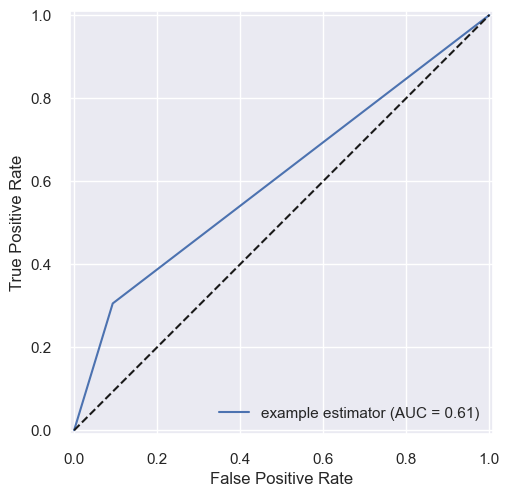

In [308]:
fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

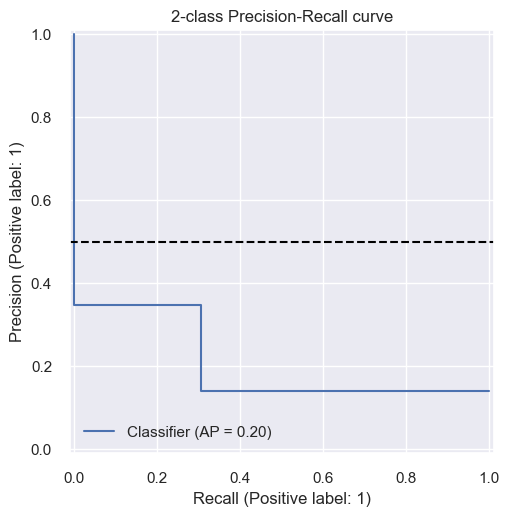

In [309]:

PrecisionRecallDisplay.from_predictions(y_test, y_predictions)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title("2-class Precision-Recall curve")
plt.show()

In [310]:
# get the best performing model
model = model.export_model()

# summarize the loaded model
model.summary()

# save the best performing model to file
#model.save('model_sonar.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 42)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 42)               85        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33    

### AUC-ROC (Area Under the Receiver Operating Characteristic curve)
#### Measures the performance of a binary classifier by plotting true positive rate against false positive rate at various threshold settings. It is particularly useful for imbalanced dataset

### AUC-PR (Area Under the Precision-Recall curve)
#### Evaluates the performance of a binary classifier by plotting precision against recall at various threshold settings. It is an alternative to AUC-ROC for imbalanced datasets.

#### Accuracy measures prediction match with true labels in classification. Precision, recall, and F1 score handle imbalanced datasets, while AUC-ROC and AUC-PR measure binary classifier performance.

#### https://gitnux.org/tensorflow-metrics/

### Reference
    
    https://physionet.org/content/challenge-2012/1.0.0/
    
    https://medium.com/@mzia.bese19seecs/complete-guide-to-autokeras-745340d0fe40
    https://machinelearningmastery.com/autokeras-for-classification-and-regression/
    https://pyimagesearch.com/2019/01/07/auto-keras-and-automl-a-getting-started-guide/
    https://www.linkedin.com/pulse/autokeras-new-revolution-deep-learning-360-digitmg
    https://www.e2enetworks.com/blog/step-by-step-guide-to-learning-autokeras-for-deep-learning
    https://itnext.io/python-and-autokeras-cbf9f1dbaa04
    https://ogsconnect.medium.com/exploring-automl-to-address-class-imbalance-75106c2aac83
    https://medium.com/nerd-for-tech/multi-class-classification-using-auto-keras-9e90684f99aa
    https://keras.io/examples/structured_data/imbalanced_classification/
